Скачаем и рахархивируем заранее все данные, которые понадобятся на семинаре + установим недостающий модуль

In [5]:
!wget https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip  # Carvana dataset
!wget https://www.dropbox.com/s/k886cusbuc1afnq/imagenet-mini.zip  # mini image-net dataset
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt  # классы имаджнета
!unzip -q CARVANA.zip
!unzip -q imagenet-mini.zip
!rm -rf ./train/.DS_Store
!rm -rf ./train_masks/.DS_Store
!pip install colour

--2020-10-28 23:30:49--  https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.1, 2620:100:601c:1::a27d:601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tc1qo73rrm3gt3m/CARVANA.zip [following]
--2020-10-28 23:30:49--  https://www.dropbox.com/s/raw/tc1qo73rrm3gt3m/CARVANA.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0347c00f0c7c6c6e1691117e7f.dl.dropboxusercontent.com/cd/0/inline/BCJrMi5H120LUivgcJh6Huzjgak-w7hQk5I0iP2OMMfCqfX6o2ymjXf_vFbHA5BTg43_8iQeUpBbZp8FlweVVAW4Y0otn6SiwJdFxAs6IlcEBty1UmrSwUpAl6gjH-IjBWo/file# [following]
--2020-10-28 23:30:49--  https://uc0347c00f0c7c6c6e1691117e7f.dl.dropboxusercontent.com/cd/0/inline/BCJrMi5H120LUivgcJh6Huzjgak-w7hQk5I0iP2OMMfCqfX6o2ymjXf_vFbHA5BTg43_8iQeUpBbZp8FlweVVAW4Y0otn6SiwJdFxAs6IlcEBty1UmrSw

In [6]:
!ls -l

total 940276
-rw-r--r-- 1 root root 461489772 Oct 28 23:30 CARVANA.zip
-rw-r--r-- 1 root root     30564 Oct 28 23:31 imagenet1000_clsidx_to_labels.txt
drwxr-xr-x 3 root root      4096 Oct 28 12:59 imagenet-mini
-rw-r--r-- 1 root root 500806504 Oct 28 23:31 imagenet-mini.zip
drwxr-xr-x 5 root root      4096 Oct 28 23:31 __MACOSX
drwxr-xr-x 1 root root      4096 Oct 14 16:31 sample_data
drwxr-xr-x 2 root root    221184 Oct 28 23:31 train
drwxr-xr-x 2 root root    262144 Oct 28 23:31 train_masks


<h2>Часть 1. mean Average Precision

Для определения метрики mean Average Precision понадобятся проделать небольшой путь и вспомнить пару понятий

Вспоминаем второй класс ИАДа:
<br>
$$ Precision = {TP \over TP + FP} $$
<br>
$$ Recall = {TP \over TP + FN} $$
<br>
<br>TP - True Positive
<br>FP - False Positive
<br>FN - False Negative
<br> <br> __Precision__ - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными

__Recall__ - показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм. 

<h4>Вспоминаем лекцию 6:
Intersection over Union</h4>
<img src=https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png>


В задаче детекции метки TP, FP, FN (чаще всего) выдаются по следующей логике
- метка TP выдается в случае если IoU > 0.5 и класс определен правильно
- метка FP выдается в случае если IoU <= 0.5 и/или если Bounding Box'ы дублируются
- метка FN выдается если если IoU > 0.5, но неправильно определен класс и/или если бокса нет совсем

<h3> Чтобы было нагляднее: </h3>
* зеленый цвет - истинный бокс и класс, синий - наши предсказания
<br> <h3>True Positive </h3> У нас два волка, оба определены своим классом и боксы очевидно имеют IoU больше 0.5 </br>
<br>
<img src="https://github.com/hse-ds/iad-deep-learning/raw/master/sem06/TruePositiveVolks.jpg">

<br> <h3>False Positive </h3> Несмотря на то, что класс определен правильно и бокс в целом выглядит логично на своем месте, IoU слишком мал, поэтому такая детекция получает метку FP </br>
<br>
<img src="https://github.com/hse-ds/iad-deep-learning/raw/master/sem06/FalsePositiveVolk.jpg">

<br> <h3>False Negative </h3> Потому что несмотря на хорошее пересечение предсказанного бокса с целевым, класс с высокой уверенностью определен неправильно </br>
<br>
<img src="https://github.com/hse-ds/iad-deep-learning/raw/master/sem06/FalseNegativeVolk.jpg">

Далее, нужно построить PR-кривую (Напоминание: это кривая, у которой по оси Y - значение Precision, а по оси X - значение recall. Эти значения считаются при переборе пороговых вероятностей, начиная с которых объект помечается положительным классом)
<br><br> Для задачи бинарной классификации мы когда-то строили такую кривую, теперь рассмотрим чуть более сложный случай, где у нас три класса: Волк, Лев и Тигр + решается задача детекции, а не классификации.
<br><br> Внизу представлена таблица с игрушечными данными по предсказаниям модели. 
<br><br>Допустим из 7 объектов, в датасете у нас только 3 волка. В данном случае мы называли объект "действительно волком" если он имел правильный класс и IoU не менее 0.5. Таким образом имеем задачу вида one vs all, где интересующим нас классом будет являться именно "волк"

|Номер строки| Уверенность в том что волк (истинный класс)    |IoU не менее 0.5?   |  Precision  |  Recall |
|------------|------------------------|----------------------|-------------|---------| 
|1           |0.92 (Волк)     |   True    |    1.0     |    0.33 |
|2           |0.83 (Волк)     |   True    |    1.0     |    0.67 | 
|3           |0.77 (Волк)     |   False   |    0.67    |    0.67 | 
|4           |0.71 (Лев)      |   False   |    0.50    |    ...  |
|5           |0.67 (Тигр)     |   False   |    0.40    |    .... | 
|6           |0.54 (Волк)     |   True    |    0.50    |    .... | 
|7           |0.47 (Тигр)     |   False   |    0.50    |    1.0  |

<h6>Посчитаем Precision и Recall для порога в 0.9:</h6>
<br> Здесь все легко, взяли порог в 0.9 и называем волками всех, у кого уверенность в классе "Волк" больше 0.9. Один TP, отсутсвуют FP и два FN (2 и 6 строчки). 
<br> $$Precision ={  1 \over 1 + 0} = 1.0$$
<br> $$Recall = {1 \over 1 + 2} = 0.33$$

<h6>для порога в 0.8:</h6> 
<br> Здесь тоже без дополнительных сложностей. С таким порогом, во второй строчке у нас нашелся еще один TP, соотоветственно убавился один FN. Остальное осталось так же
<br> $$Precision ={  2 \over 2 + 0} = 1.0$$
<br> $$Recall = {2 \over 2 + 1} = 0.67$$

<h6>для порога в 0.75:</h6>  
<br> А вот при пороге в 0.75 в третьей строчке замечаем, что несмотря на то, что истинный класс действительно "Волк", чем мы и называем данный объект - IoU c истинным боксом меньше 0.5, поэтому присваиваем метку FP.
<br> $$Precision ={  2 \over 2 + 1} = 0.67$$
<br> $$Recall = {2 \over 2 + 1} = 0.67$$

<br> <br> <h6>Дальше сами :)</h6>
<br> <h6>Задание: Посчитать недостающие в таблице значения precision и recall и сравнить с изображенной PR кривой</h6>

PR кривая будет вылядеть следуюшим образом:

<img src="https://github.com/hse-ds/iad-deep-learning/raw/master/sem06/pr_uno.png">

Average Precision (AP) стандартно определяется как AUC-PR, то есть как площадь по PR кривой. Из-за того, что Precision и Recall находятся в отрезке от 0 до 1, AP так же определена на этом отрезке. Чем ближе к 1, тем качественнее модель

* Для удобства вычислений, и чуть большей устойчивости к перестановке - вместо того, чтобы терпеть возникшую немонотонность, для всех совпадающих значений recall'a берется максимальный справа от текущей точки precision, то есть график изменится следующим образом:


<img src="https://github.com/hse-ds/iad-deep-learning/raw/master/sem06/pr_dos.png">



Технология та же - для вычисления AP считается AUC под красной кривой
<br> $$AP = 1 * 0.67 + (1 - 0.67) * 0.5 = 0.835 $$

* <br>В какой-то момент люди решили, что просто площади теперь не круто и в популярном соревновании PASCAL VOC2008 для вычисления Average Precision использовалась 11-point interpolation. 
<br>По-простому: брались 11 значений монотонной PR функции, в точках 0, 0.1, 0.2, ..., 0.9, 1.0 и усреднялись. <br>Для любителей формул:

<br> $$AP = {1 \over11} * \sum P(r), r \in [0.1, 0.2, ..., 0.9, 1.0]$$
<br> P(r) - значение Precision при определенном Recall
<br> 
<br> графически это все выглядит следующим образом:


<img src="https://github.com/hse-ds/iad-deep-learning/raw/master/sem06/pr_tres.png">



Посчитаем АР данным способом:
<br> $$AP = {1 \over {11}} (1 * 7 + 3 * 0.5) = 0.77 $$

* Для более <font color="green">fresh </font> PASCAl VOC соревнований (2011 - 2012) было принято решение считать Average Precision как обычную __площадь под монотонной PR кривой__. Этого определения мы и будем придерживаться далее

Все предыдущие графики, наша первая табличка и значения AP считались для одного класса "Волк". Понятно, что подобные значения можно посчитать для каждого класса в выборке. И каждый раз будет принцип one vs all, где различается нужный класс и "все остальные"
<br><br>Метрика __mean Average Precison__ считается как среднее между __AP__ каждого класса, те:

$$mAP = \sum_{c \in C} AP(c)$$
где С - множество классов

Ниже - пример того как считать среднее :)) 
<br>*для Average Precision льва и тигра значения взяты случайно

|AP(Волк)| AP(Лев) | AP(Тигр)|mAp    |
|--------|---------|---------|-------|
|0.835   |0.83     | 0.77    | 0.81  |

---

<h2>Часть 2. Semantic segmentation

In [31]:
import os
from os.path import isfile, join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models

from colour import Color

from tqdm import tqdm

from PIL import Image

import cv2

<h> В этой части семинара мы напишем свой U-net с нуля, без мам, пап и кредитов,
обучим и попробуем его на задачу распознавания точной маски автомобиля

In [8]:
class Carvana(Dataset):

    def __init__(
        self,
        root,
        transform=None,
        ):
        """

        :param root: путь к папке с данными
        :param transform: transform the images and labels
        """

        self.root = os.path.expanduser(root)
        self.transform = transform
        (self.data_path, self.labels_path) = ([], [])

        def load_images(path):
            """
            returns all the sorted image paths.

            :param path:
            :return: лист с путями до всех изображений
            """

            images_dir = [join(path, f) for f in os.listdir(path)
                          if isfile(join(path, f))]
            images_dir.sort()

            return images_dir

        self.data_path = load_images(self.root + '/train')
        self.labels_path = load_images(self.root + '/train_masks')

    def __getitem__(self, index):
        """

        :param index:
        :return: tuple (img, target) with the input data and its label
        """

        img = Image.open(self.data_path[index])
        target = Image.open(self.labels_path[index])

        if self.transform is not None:
            img = self.transform(img)
            target = self.transform(target)
            target = (target > 0).float()

        return (img, target)

    def __len__(self):
        return len(self.data_path)

def im_show(img_list):
    """
    It receives a list of images and plots them together
    :param img_list:
    :return:
    """

    to_PIL = transforms.ToPILImage()
    if len(img_list) > 9:
        raise Exception('len(img_list) must be smaller than 10')

    for (idx, img) in enumerate(img_list):
        img = np.array(to_PIL(img))
        # plt.subplot(100 + 10 * len(img_list) + idx + 1)
        plt.figure(figsize=(4,4))
        fig = plt.imshow(img)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.show()

Загрузим датасет при помощи определенного выше класса

In [9]:
train_dataset = Carvana(root='.',
                        transform=transforms.Compose([
                            transforms.Resize((256, 256)),
                            transforms.ToTensor()])
                        )

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=1)

Посмотрим несколько примеров изображений и масок автомобиля

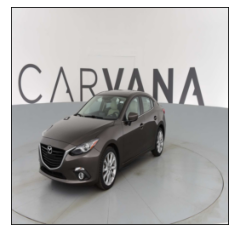

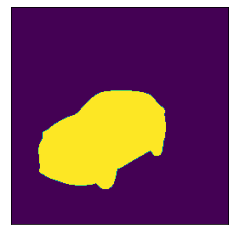

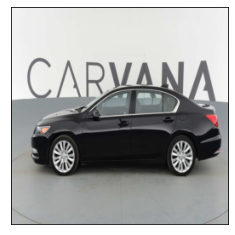

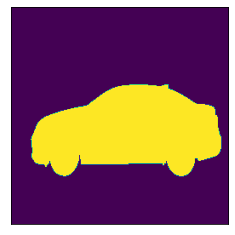

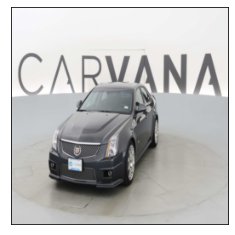

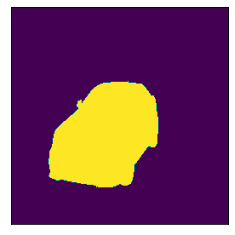

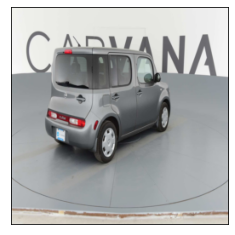

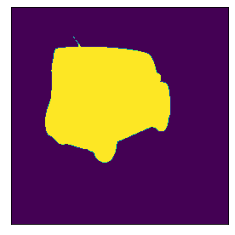

In [10]:
img_list = []
for i in range(4):
    img, label = train_dataset[np.random.randint(0, 100)]
    img_list.append(img)
    img_list.append(label)

im_show(img_list)

Дополните недостающий код таким образом, чтобы получилась архитектура U-net (https://arxiv.org/pdf/1505.04597.pdf) сети. Обратите внимание, что при проходе "вниз" количество каналов каждого блока __увеличивается в два раза__. Ситуация с проходом "вверх" противоположна, количество каналлов __уменьшается вдвое__. Также, начинаем мы __не с 64 каналов__, как на схеме ниже, __а с 16 каналов__. 
<br>При проходе вниз в нашей реализации предлагается __дойти до 128 каналов__, чтобы сэкономить время обучения, в оригинальной статье было до 1024. (2 блока, вместо 4х)
<br>В целом, при отличии количества каналлов от указанных выше чисел - модель все равно будет работать, но для удобства проведения семинара лучше всем договориться об одних числах
<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png">
<br> Подсказка: каждый блок по пути "вниз" представляет из себя двойную свертку с батч нормом и активацией (при создании Relu слоя не забывайте inplace=True)

In [11]:
class ConvBlock(nn.Module):

    def __init__(self, in_size, out_size, kernel_size=3, padding=1, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_size, out_size, kernel_size,  # <YOUR CODE HERE>
                              padding=padding, stride=stride)
        self.bn = nn.BatchNorm2d(out_size)
        self.relu = nn.ReLU(inplace=True) # <YOUR CODE HERE>

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        self.down_1 = nn.Sequential(
            ConvBlock(3, 16),
            ConvBlock(16, 32, stride=2, padding=1))

        self.down_2 = nn.Sequential(  # <YOUR CODE HERE>
            ConvBlock(32, 64),
            ConvBlock(64, 128))

        self.middle = ConvBlock(128, 128, kernel_size=1, padding=0)

        self.up_2 = nn.Sequential(  # <YOUR CODE HERE>
            ConvBlock(256, 128),
            ConvBlock(128, 32))

        self.up_1 = nn.Sequential(  # <YOUR CODE HERE>
            ConvBlock(64, 64),
            ConvBlock(64, 32))

        self.output = nn.Sequential(
            ConvBlock(32, 16),
            ConvBlock(16, 1, kernel_size=1, padding=0))

    def forward(self, x):
        down1 = self.down_1(x)  # <YOUR CODE HERE>
        out = F.max_pool2d(down1, kernel_size=2, stride=2)

        down2 = self.down_2(out)  # <YOUR CODE HERE>
        out = F.max_pool2d(down2, kernel_size=2, stride=2)  # <YOUR CODE HERE>

        out = self.middle(out)

        out = nn.functional.interpolate(out, scale_factor=2)  # интерполяцией увеличиваем размер фильтра вдвое
        out = torch.cat([down2, out], 1)
        out = self.up_2(out)

        out = nn.functional.interpolate(out, scale_factor=2)  # <YOUR CODE HERE>
        out = torch.cat([down1, out], 1)   # <YOUR CODE HERE>
        out = self.up_1(out)   # <YOUR CODE HERE>

        out = nn.functional.interpolate(out, scale_factor=2)
        return self.output(out)

Определяем функцию для обучения одной эпохи

In [12]:
def train(train_loader, model, criterion, epoch, num_epochs):
    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = torch.sigmoid(model(images))
        
        loss = criterion(outputs, labels)
        
        accuracy = ((outputs > 0.5) == labels).float().mean()
            
        pbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
        )

        loss.backward()
        optimizer.step()

In [13]:
model = Unet().cuda()
criterion = torch.nn.BCELoss().cuda()  # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
optimizer = torch.optim.RMSprop(model.parameters(),
                                weight_decay=1e-4,
                                lr=1e-4,
                                momentum=0.9)

num_epochs = 1
for epoch in range(0, num_epochs):
    train(train_loader, model, criterion, epoch, num_epochs)

Loss: 0.5968 Accuracy: 96.7478: 100%|██████████| 40/40 [03:37<00:00,  5.44s/it]


Посмотрим на результаты

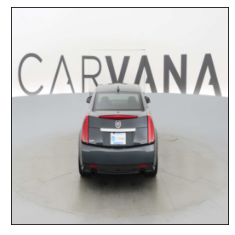

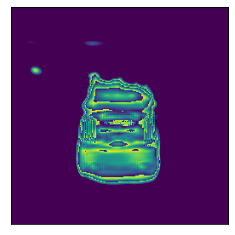

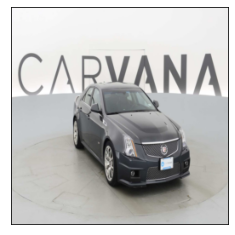

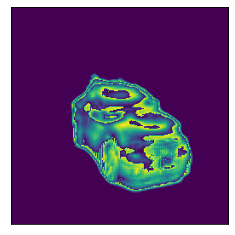

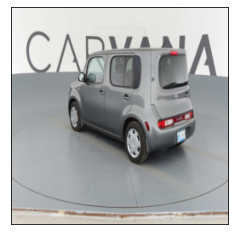

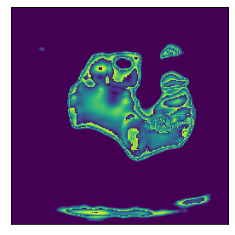

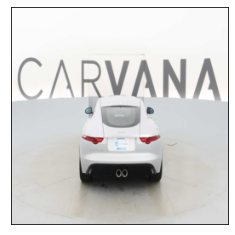

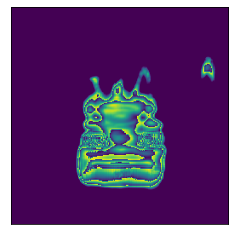

In [15]:
img_list = []
for i in range(4):
    img, label = train_dataset[np.random.randint(0, 100)]
    img_list.append(img)
    img_list.append(model(img.unsqueeze(0).cuda()).squeeze(0).cpu())

im_show(img_list)

Еще несколько эпох и никакие гринскрины нужны не будут...

In [16]:
#освободим память
model.cpu()

del model

---

<h2>Часть 3. Интерпретация</h2>
<br> Давайте попробуем понять куда смотрит нейросеть при определении класса. Обратите внимание, здесь речь пройдет про интерпретацию нейросети, решающей задачу классификации

Основная идея следующего эксперимента взята из статьи https://people.csail.mit.edu/khosla/papers/iclr2015_zhou.pdf. Авторы утверждают, что в нейросетях, обученных на классификацию сцен возникают детекторы объектов, подсказывающие сетке что за сцена перед ней. Так например при прогоне изобрадения картинной галлереи возникают детекторы картин, в спальне - детекторы тумбочек и кроватей, а на улице - детекторы гидрантов.

<br> Реализация следующих кусков кода значительно проще, но цель эксперимента остается неизменной: хотим понять куда смотрит нейросеть, обученная на классификацию </br>

<br> Алгоритм идейно следующий:</br> 
<br>1. Берем любое изображение из валидационной выборки, делаем для него предсказание. Запоминаем уверенность модели в предсказании.</br> 
<br>2. Копируем изображение, частично (квадратиком NxN) перекрывая всевозможные его части</br>
<br>3. Прогоняем частично перекрытые изображения через модель</br>
<br>4. Смотрим насколько изменилась уверенность в прелсказании при перекрытии каждой части </br>
<br>Гипотеза в том, что если уверенность упала сильно, то перекрытый участок важен для нейросети и именно на этот участок она смотрит </br>
<br>Таким образом можем покрасить участки изображения в разные цвета и получить красивую heatmap'у</br>

Определим пару вспомогательных функций

In [14]:
device = torch.device("cpu")

In [16]:
def imshow(img):
    """
    img: normalized torch.Tensor
    """
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def predict(model, images: torch.Tensor) -> torch.Tensor:
    model.eval()
    if len(images.size()) == 3:  # для одного изображения
        preds = model.forward(images.unsqueeze(0))
    elif len(images.size()) == 4:  # для нескрльки изображений
        preds = model.forward(images)
    
    return torch.softmax(preds, dim=-1)

Загрузим датасет. Наша выборка - подмножество классического ImageNet.

In [17]:
batch_size = 100

# преобразуйте изображения в размер 256х256
# вырежьте центральную часть размера 240х24
# переведите в тип данных торч тензор
# и нормализуйте согласно следующим числам
norm_means = torch.from_numpy(np.array([0.485, 0.456, 0.406]))
norm_stds = torch.from_numpy(np.array([0.229, 0.224, 0.225]))

transform = transforms.Compose(  # <YOUR CODE HERE>
    [
        transforms.Resize(256),# <YOUR CODE HERE>
        transforms.CenterCrop(240),# <YOUR CODE HERE>
        transforms.ToTensor(),# <YOUR CODE HERE>
        transforms.Normalize(# <YOUR CODE HERE>
                             mean=norm_means,# <YOUR CODE HERE>
                             std=norm_stds # <YOUR CODE HERE>                 
                             )# <YOUR CODE HERE>
     ])

testset = torchvision.datasets.ImageFolder(root='imagenet-mini/', 
                                              transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                 shuffle=True, num_workers=0)

In [18]:
dataiter_imagenet = iter(testloader)
test_images, test_labels = dataiter_imagenet.next()

Для нашего эксперимента возьмем предобученную модель VGG11 с батч нормализацией

In [19]:
model  = torchvision.models.vgg11_bn(pretrained=True).eval()
model  = model.to(device)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


In [22]:
# словарь вида "номер класса": "его название"
NUMBER_TO_CLASS = {}
# словарь вида "название класса": "его номер"
CLASS_TO_NUMBER = {}

with open("imagenet1000_clsidx_to_labels.txt", "r") as f:  # файл с перечислением классов имаджнета в определенном порядке
    for line in f.readlines():
        line = line.replace("{", "").replace("}", "")
        class_number, class_name = line.split(':')
        class_name = class_name.split(',')[0].replace("'", '').replace(" ", "").replace('"', "")
        
        NUMBER_TO_CLASS[int(class_number)] = class_name
        CLASS_TO_NUMBER[class_name] = int(class_number)    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


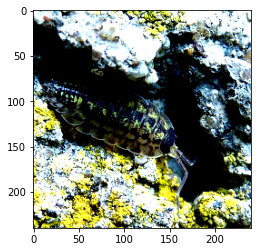

In [23]:
test_image = test_images[12]
imshow(test_image)

In [24]:
# предсказания модели, 1000-мерный вектор
predictions = predict(model, test_image)

# получим из всех предсказаний label(строковое обозначение) наиболее уверенного класса
class_label = NUMBER_TO_CLASS[int(torch.argmax(predictions))]  # <YOUR CODE HERE>
# запишем номер этого класса
class_number = CLASS_TO_NUMBER[class_label]  # <YOUR CODE HERE>

# и запишем вероятность этого класса
normal_class_prob = torch.max(predictions).item()  # <YOUR CODE HERE>

print('№', class_number, "|class_label:",class_label, "|probability:", normal_class_prob)

№ 126 |class_label: isopod |probability: 0.9818235635757446


Определяем и реализуем функцию для получения списка частично перекрытых копий исходного изображения

In [26]:
def compute_ocluded_copies(image: torch.tensor, patch_size: (int, int)) -> [torch.tensor]:
    """
    image: нормализованный тензор изображения
    patch_size: размер окна, которым будем проходиться и перекрывать изображение
    
    return: список изображений на каждом из которых закрыта определенная часть размера patch_size

    !А еще предполагаем что входящие изображения - квадратные!
    """
    
    ans = []
    
    _, width, height = image.size()
    for h in range(0, height, patch_size[0]):
        for w in range(0, width, patch_size[1]):
            temp = image.numpy()
            temp = np.transpose(temp, (1, 2, 0))
            temp = cv2.UMat(temp).get()  # 3 строчки никому не интересных танцев с типами данных
            
            # непосредственно само закрашивание
            img = cv2.rectangle(img=temp,  # само изображение
                     pt1=(w, h), 
                     pt2=(w + patch_size[0], h + patch_size[1]), 
                     color=(0, 0, 0),  # цвет квадрата
                     thickness=-1)  # квадрат заполнить цветом
            
            temp = np.transpose(temp , (2, 0, 1))
            temp = torch.from_numpy(temp)
            ans.append(temp)
        
    return  torch.stack(ans)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


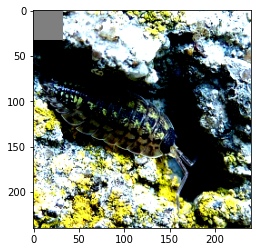

In [27]:
# чем меньше размера патча, тем красивее и детальнее получится heatmap
# но из-за того что гугл не дает много оперативки, а автор семинара не захотел
# задумываться об оптимальной реализации предыдущей функции - оставим 32х32 :)
patch_size = (32, 32)
# получаем список частично перекрытых копий исходного изображения
ocluded_images = compute_ocluded_copies(image=test_image, 
                                        patch_size=patch_size)
imshow(ocluded_images[0])

*здесь возможно придется немного подождать

In [28]:
# получим уверенности предсказания для частично перекрытых изображений
ocluded_predictions = predict(model, ocluded_images)

# для каждого частично перекрытого изображения 
# соберем в list уверенности в предсказании того класса, который был предсказан до всяких перекрытий
ocluded_class_probs = [x[class_number].item() for x in ocluded_predictions]  # <YOUR CODE HERE>

In [29]:
def draw_heatmap(originial_image: torch.Tensor, 
                 normal_pred:     float, 
                 ocluded_preds:   [float], 
                 patch_size:      (int, int),
                 alpha:           int = 1) -> None:

    # для каждого частично перекрытого изображения 
    # считаем разницу между исходной уверенностью и уверенностью после перекрытия
    diffs = np.abs(np.array(ocluded_preds) - normal_pred)
        
    # находим минимальную и максимальную разницу чтобы минимальной присвоить синий цвет, максимальной - красный
    mindiff, maxdiff = diffs.min(), diffs.max()  # <YOUR CODE HERE>

    # устанавливаем количество цветов в нашей хитмапе
    # красный цвет - участок наиболее важен, синий цвет - участок наименее важен
    colors_count = 10
    colors = list(Color("blue").range_to(Color("red"), colors_count))
    
    # генерируем массив чисел с равными расстояними от mindiff до maxdiff
    # как бы выделяем по одному отрезку на каждый цвет
    tresholds = np.arange(mindiff, maxdiff, (maxdiff - mindiff) / colors_count)  # <YOUR CODE HERE>
    
    _, width, height = originial_image.size()
    
    counter = 0
    
    original_umat = originial_image.numpy()
    original_umat = np.transpose(original_umat, (1, 2, 0))
    original_umat = cv2.UMat(original_umat).get()  # просто преобразования между типами данных
    
    # Наша heatmap будет представлять собой исходное изображение,
    # у которого каждый пиксель закрашен каким-то цветом
    overlay = original_umat.copy()

    for h in range(0, height, patch_size[0]):
        for w in range(0, width, patch_size[1]):
            
            # расстояния
            distances = np.abs(tresholds - diffs[counter])
            counter += 1 


            # находим номер наиближайшего порога
            closest_treshold_number = np.argmin(distances)
            color = colors[closest_treshold_number].rgb
            
            
            cv2.rectangle(overlay, (w, h), (w + patch_size[0], h + patch_size[1]),
                          color, -1)  # original image with opaque colored patch
            
            
    # накладываем наше закрашенное изображение с некоторой прозрачностью alpha на исходное
    final = cv2.addWeighted(overlay, alpha , original_umat, 1 - alpha, 0)  # adding colored box to original
    final = np.transpose(final , (2, 0, 1))
    final = torch.from_numpy(final)        
    imshow(final)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


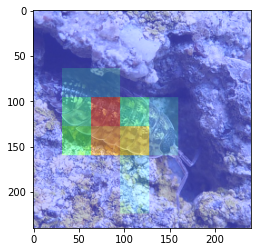

In [30]:
draw_heatmap(originial_image=test_image, 
             normal_pred=normal_class_prob, 
             ocluded_preds=ocluded_class_probs, 
             patch_size=patch_size,
             alpha=0.7)

Время от времени, в зависимости от картинки, конечно можно наблюдать довольно осмысленные хитмапы даже таким примитивным способом. Попробуйте прогнать несколько изображений

Интересные статейки ссылчки по интерпретации

<br> https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf
<br> https://arxiv.org/abs/1412.6856
<br> http://places.csail.mit.edu/places_NIPS14.pdf
<br> https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
<br> https://arxiv.org/pdf/1901.02413.pdf
